In [1]:
# import sys
# import os

# sys.path.append(os.path.abspath("../code"))

In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from utils import *
from generate_data import * 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from network import *

from torch_functions import *

from plot_data import *
from data_loading import *

import json

from ellipsoid_predictor import *
from hyper_rectangles import *


In [4]:
seed_everything(44)

config_name = "scm1d001"

config_path = "../parameters/" + config_name + ".json"
with open(config_path, 'r') as file : 
    parameters = json.load(file)


prop_train = parameters["prop_train"]
prop_calibration = parameters["prop_calibration"]

# Chemin d'entrée et de sortie
load_path = "../../../data/processed_data/" + parameters["load_name"] + ".npz"

# Exemple d'utilisation du loader
X, Y = load_data(load_path)




normalize = parameters["normalize"]
splits = [parameters["prop_train"], parameters["prop_stop"], parameters["prop_calibration"], parameters["prop_test"]]

subsets = split_and_preprocess(X, Y, splits=splits, normalize=normalize)

x_train, y_train, x_calibration, y_calibration, x_test, y_test, x_stop, y_stop = subsets["X_train"], subsets["Y_train"], subsets["X_calibration"], subsets["Y_calibration"], subsets["X_test"], subsets["Y_test"], subsets["X_stop"], subsets["Y_stop"]

print("X_train shape:", x_train.shape, "Y_train shape:", y_train.shape)
print("X_cal shape:", x_calibration.shape, "Y_cal shape:", y_calibration.shape)
print("X_test shape:", x_test.shape, "Y_test shape:", y_test.shape)
print("X_stop shape:", x_stop.shape, "Y_stop shape:", y_stop.shape)

d = x_train.shape[1]
k = y_train.shape[1]

n_train = x_train.shape[0]
n_test = x_test.shape[0]
n_calibration = x_calibration.shape[0]
n_stop = x_stop.shape[0]

hidden_dim = parameters["hidden_dim"]
hidden_dim_matrix = parameters["hidden_dim_matrix"]
n_hidden_layers = parameters["n_hidden_layers"]
n_hidden_layers_matrix = parameters["n_hidden_layers_matrix"]

num_epochs_warm_start = parameters["num_epochs_warm_start"]
warm_start_epochs_mat = parameters["warm_start_epochs_mat"]
num_epochs_our_loss = parameters["num_epochs_our_loss"]

lr_warm_start = parameters["lr_warm_start"]
lr_model = parameters["lr_model"]
lr_matrix = parameters["lr_matrix"]
lr_q = parameters["lr_q"]

batch_size_warm_start = parameters["batch_size_warm_start"]
batch_size_our_loss = parameters["batch_size_our_loss"]

n_neighbors = parameters["n_neighbors"]
use_lr_scheduler = parameters["use_lr_scheduler"]
keep_best = parameters["keep_best"]

num_epochs_rectangles = parameters["num_epochs_rectangles"]
lr_rectangles = parameters["lr_rectangles"]
batch_size_rectangles = parameters["batch_size_rectangles"]

loss_strategy = parameters["loss_strategy"]
use_epsilon = parameters["use_epsilon"]

dtype = torch.float32 if parameters["dtype"] == "float32" else torch.float64

alpha = parameters["alpha"]
print(alpha)

X_train shape: (15129, 17) Y_train shape: (15129, 2)
X_cal shape: (2161, 17) Y_cal shape: (2161, 2)
X_test shape: (2162, 17) Y_test shape: (2162, 2)
X_stop shape: (2161, 17) Y_stop shape: (2161, 2)


In [ ]:
x_train_tensor = torch.tensor(x_train, dtype=dtype)
y_train_tensor = torch.tensor(y_train, dtype=dtype)
x_stop_tensor = torch.tensor(x_stop, dtype=dtype)
y_stop_tensor = torch.tensor(y_stop, dtype=dtype)
x_calibration_tensor = torch.tensor(x_calibration, dtype=dtype)
y_calibration_tensor = torch.tensor(y_calibration, dtype=dtype)
x_test_tensor = torch.tensor(x_test, dtype=dtype)
y_test_tensor = torch.tensor(y_test, dtype=dtype)

matrix_model = MatrixPredictor(d, k, k, hidden_dim=hidden_dim_matrix).to(dtype=dtype)
model = Network(d, k, hidden_dim=hidden_dim, n_hidden_layers=n_hidden_layers).to(dtype=dtype)
q = torch.tensor(2.0, dtype=dtype, requires_grad=True)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size_warm_start, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size_warm_start, shuffle=True)
train_losses, stop_losses = model.fit_and_plot(trainloader, stoploader, epochs=num_epochs_warm_start, lr=lr_warm_start, keep_best=keep_best)

warm_start_model = copy.deepcopy(model)

In [6]:
lr_warm_start

0.0001

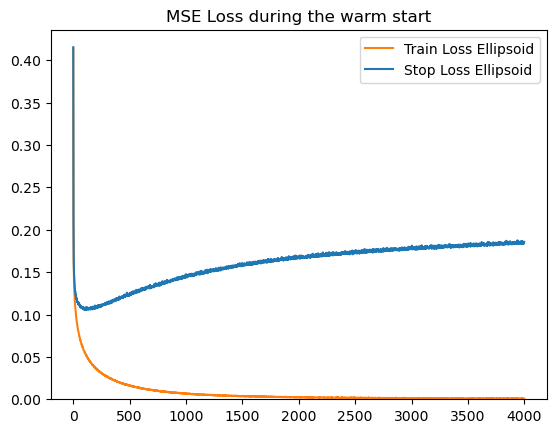

In [7]:
# Define colors for each model
half_ellipsoid_color = 'tab:blue'
ellipsoid_color = 'tab:orange'

plt.plot(train_losses, linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
plt.plot(stop_losses, linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')

plt.title("MSE Loss during the warm start")
plt.ylim(bottom=0)
plt.legend()
plt.show()
plt.close()

In [8]:
print(lr_matrix)
print(np.argmin(stop_losses))
print(np.min(stop_losses))

0.0007
98
0.10549624118587589


In [9]:
# 0.0001
# 1796
# 0.150977564489648

In [10]:
print(loss_strategy)
q = torch.tensor(2.0, dtype=dtype, requires_grad=True)

log_volume


In [11]:
# batch_size_our_loss = 200
# lr_matrix = 0.0001
# lr_q = 0.0001
# lr_matrix = 0.00005
# lr_model = 0.0005

# lr_q = 0.01
# lr_model = 0.001
warm_start_epochs_mat = 5000
# num_epochs_our_loss = 3000
# loss_strategy = "log_volume"
# use_epsilon = False
# use_lr_scheduler = True
# loss_strategy = "exact_volume"

model = copy.deepcopy(warm_start_model).to(dtype=dtype)
matrix_model = MatrixPredictor(d, k, k, hidden_dim=hidden_dim_matrix).to(dtype=dtype)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size_our_loss, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size_our_loss, shuffle=True)
calibrationloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_calibration_tensor, y_calibration_tensor), batch_size= batch_size_our_loss, shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor), batch_size= batch_size_our_loss, shuffle=True)

ellipsoid_predictor = EllipsoidPredictor(model, matrix_model, q)

ellipsoid_predictor.fit(trainloader, 
                        stoploader, 
                        alpha,
                        num_epochs = num_epochs_our_loss,
                        num_epochs_mat_only = warm_start_epochs_mat,
                        lr_model =lr_model,
                        lr_q = lr_q,
                        lr_matrix_model = lr_matrix,
                        use_lr_scheduler = use_lr_scheduler,
                        verbose = 2,
                        stop_on_best = keep_best,
                        loss_strategy = loss_strategy,
                        use_epsilon = use_epsilon,
                        )

New best stop loss: 73.93355358092089
Epoch 0: Loss = 64.29481583019589 - Stop Loss = 73.93355358092089 - Best Stop Loss = 73.93355358092089
Epoch 1: Loss = 74.66804126625863 - Stop Loss = 87.65520932534193 - Best Stop Loss = 73.93355358092089
Epoch 2: Loss = 68.78122563104182 - Stop Loss = 84.14979740501015 - Best Stop Loss = 73.93355358092089
Epoch 3: Loss = 65.67494569630095 - Stop Loss = 85.20411752068809 - Best Stop Loss = 73.93355358092089
Epoch 4: Loss = 63.84139794473029 - Stop Loss = 79.65422793770514 - Best Stop Loss = 73.93355358092089
Epoch 5: Loss = 69.9454833060358 - Stop Loss = 80.33803037615192 - Best Stop Loss = 73.93355358092089
Epoch 6: Loss = 65.82947066299755 - Stop Loss = 80.04355431766419 - Best Stop Loss = 73.93355358092089
Epoch 7: Loss = 62.5053947086901 - Stop Loss = 78.83029630023319 - Best Stop Loss = 73.93355358092089
Epoch 8: Loss = 61.67184537430651 - Stop Loss = 77.50370299548375 - Best Stop Loss = 73.93355358092089
Epoch 9: Loss = 60.51115494878759 - S

KeyboardInterrupt: 

In [12]:
ellipsoid_predictor.load_best_model()

In [13]:
from covariances import *
from local_covariances import *

In [14]:
model_final_loss_calibration = ellipsoid_predictor.model.eval(calibrationloader)
warm_start_model_loss_calibration = warm_start_model.eval(calibrationloader)

if model_final_loss_calibration < warm_start_model_loss_calibration:
    covariance_predictor = CovariancePredictor(ellipsoid_predictor.model)
    local_covariance_predictor = LocalCovariancePredictor(ellipsoid_predictor.model, n_neighbors=n_neighbors)

    covariance_predictor.fit(trainloader)
    local_covariance_predictor.fit(trainloader)
    print('keeping the final model')
else:
    covariance_predictor = CovariancePredictor(warm_start_model)
    local_covariance_predictor = LocalCovariancePredictor(warm_start_model, n_neighbors=n_neighbors, dtype=dtype)
    covariance_predictor.fit(trainloader)
    local_covariance_predictor.fit(trainloader)
    print('keeping the warm started model')

keeping the final model


In [15]:
covariance_predictor.conformalize(calibrationloader, alpha = alpha)
local_covariance_predictor.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)
ellipsoid_predictor.conformalize(calibrationloader, alpha = alpha)

8


In [16]:
print(ellipsoid_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor))
print(covariance_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor))
print(local_covariance_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor))

print("")
print(ellipsoid_predictor.get_averaged_volume(x_test=x_test_tensor))
print(covariance_predictor.get_averaged_volume(x_test = x_test_tensor))
print(local_covariance_predictor.get_averaged_volume(x_test = x_test_tensor))


0.9928644299507141
0.9887869358062744
0.9887869358062744

23198986176365.305
6086086540.688193
6086086540.688177


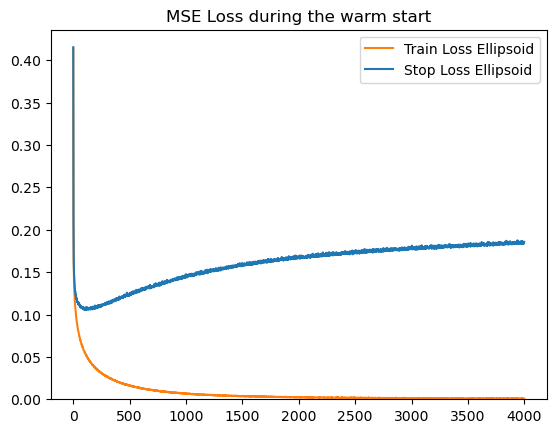

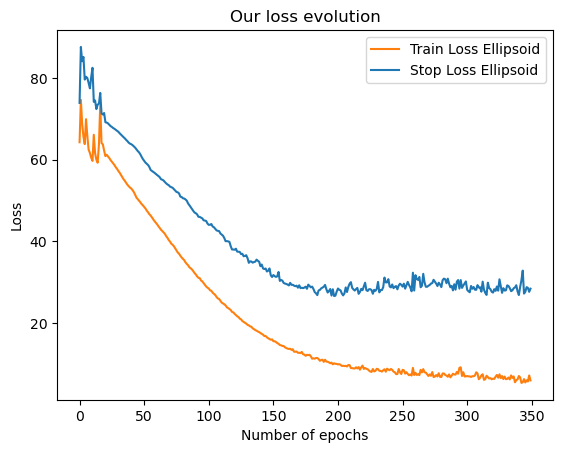

197
26.604664947804544


In [17]:
# Define colors for each model
half_ellipsoid_color = 'tab:blue'
ellipsoid_color = 'tab:orange'

plt.plot(train_losses, linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
plt.plot(stop_losses, linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')

plt.title("MSE Loss during the warm start")
plt.ylim(bottom=0)
plt.legend()
plt.show()
plt.close()

# Second plot: Loss evolution
plt.plot(ellipsoid_predictor.tab_train_loss, linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
plt.plot(ellipsoid_predictor.tab_stop_loss, linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')
# plt.plot(ellipsoid_predictor.tab_train_loss[1000:], linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
# plt.plot(ellipsoid_predictor.tab_stop_loss[1000:], linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')

plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Our loss evolution')
plt.legend()
plt.show()
plt.close()
print(np.argmin(ellipsoid_predictor.tab_stop_loss))
print(np.min(ellipsoid_predictor.tab_stop_loss))


In [18]:
hyper_rectangle_predictor = HyperRectanglePredictor(d, k, alpha, hidden_dim = hidden_dim, n_layers = n_hidden_layers)

In [19]:
n = 100
alpha = 0.1
p = np.ceil((n+1)*(1-alpha))
print(int(alpha * n) )
print(p)

10
91.0


In [20]:
hyper_rectangle_predictor.fit(x_train, y_train, x_stop, y_stop,
                              num_epochs = num_epochs_rectangles, 
                              lr = lr_rectangles,
                              batch_size = batch_size_rectangles,
                              use_lr_scheduler = use_lr_scheduler,
                              keep_best = keep_best)

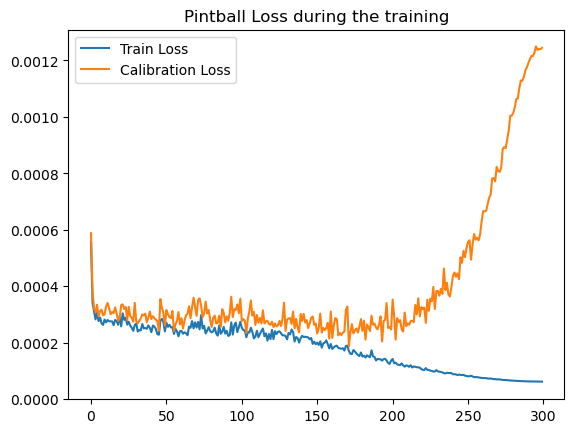

In [21]:
plt.plot(hyper_rectangle_predictor.tab_loss, label='Train Loss')
plt.plot(hyper_rectangle_predictor.tab_loss_stop, label='Calibration Loss')
plt.title("Pintball Loss during the training")
plt.ylim(bottom=0)  
plt.legend()
plt.show()
plt.close()

In [22]:
hyper_rectangle_predictor.conformalize(x_calibration, y_calibration)
volume_hyper_rectangle, coverage_hyper_rectangles = hyper_rectangle_predictor.calculate_volume_and_coverage(x_test, y_test)

print(volume_hyper_rectangle)

303615836160.0


In [ ]:
x_test_tensor = torch.tensor(x_test, dtype=dtype)
f_x_test = ellipsoid_predictor.model(x_test_tensor)
f_x_test_np = f_x_test.detach().numpy()
f_x_test_cov_np = ellipsoid_predictor.model(torch.tensor(x_test, dtype=dtype)).detach().numpy()

Lambdas_test = ellipsoid_predictor.get_Lambdas(x_test)
Lambdas_test_np = Lambdas_test.detach().numpy()

# Lambdas_test_cov = covariance_predictor.get_Lambdas(x_test)
Lambdas_test_cov = covariance_predictor._Lambda_cov.unsqueeze(0).expand(y_test.shape[0], y_test.shape[1], y_test.shape[1]).clone()
Lambdas_test_cov_np = Lambdas_test_cov.detach().numpy()

q_val = ellipsoid_predictor.q.item()

idx = np.random.choice(len(y_test), 10, replace=False)

for i in idx:
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # print(ellipsoid_predictor.get_averaged_volume(x_test=x_test_tensor[i]))
    # print(covariance_predictor.get_averaged_volume(x_test = x_test_tensor[i]))
    # volume_hyper_rectangle, coverage_hyper_rectangles = hyper_rectangle_predictor.calculate_volume_and_coverage(x_test[i], y_test[i])
    # print(volume_hyper_rectangle)
    ax.scatter(y_test[i, 0], y_test[i, 1],  c='mediumturquoise', alpha=0.5)
    ax = add_ellipse(ax,  f_x_test_np[i], Lambdas_test_np[i], q_val, ellipsoid_predictor.nu_conformal.item(), color = "red", label='Conformal Ellipse for q = {}'.format(q_val))    

    ax.grid(True)
    ax.legend( loc = "best")
    
    ax.set_xlabel('y_1')
    ax.set_ylabel('y_2')

    plt.show()
    plt.close()

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray